## Load the necessary modules

Zipline only works with an older version of pandas. It is necessary to downgrade to the version of pandas that is 0.22.0

In [63]:
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import zipline
from zipline.api import order, record, symbol
from zipline.assets import Equity, Future
from zipline import run_algorithm
from collections import OrderedDict
from datetime import datetime


## Load and Prelimenary Analysis of Data

In [24]:
# Store the different datasets
data = OrderedDict()
# Loads the data from the csv file
stocks  = ["AAPL", "AMZN", "BA", "FB", "GOOG", "MA", "MSFT", "NVDA", "UNH", "V"]

# Iterate to load stock data from csv
for stock in stocks:
    data[stock] = pd.read_csv("{}.csv".format(stock), index_col =0, parse_dates=['Date'])
    data[stock] = data[stock][["open","high","low","close","volume"]]
    print(data[stock].head(10))

             open   high    low  close     volume
Date                                             
2013-01-02  79.12  79.29  77.38  78.43  140129500
2013-01-03  78.27  78.52  77.29  77.44   88241300
2013-01-04  76.71  76.95  75.12  75.29  148583400
2013-01-07  74.57  75.61  73.60  74.84  121039100
2013-01-08  75.60  75.98  74.46  75.04  114676800
2013-01-09  74.64  75.00  73.71  73.87  101901100
2013-01-10  75.51  75.53  73.65  74.79  150286500
2013-01-11  74.43  75.05  74.15  74.33   87626700
2013-01-14  71.81  72.50  71.22  71.68  183551900
2013-01-15  71.19  71.28  69.05  69.42  219193100
              open    high     low   close   volume
Date                                               
2013-01-02  256.08  258.10  253.26  257.31  3271000
2013-01-03  257.27  260.88  256.37  258.48  2750900
2013-01-04  257.58  259.80  256.65  259.15  1874200
2013-01-07  262.97  269.73  262.67  268.46  4910000
2013-01-08  267.07  268.98  263.57  266.38  3010700
2013-01-09  268.17  269.50  265.40  

*Price of the stock of the ten companies of interest from 2013 to 2018*

Text(0, 0.5, 'Price in $')

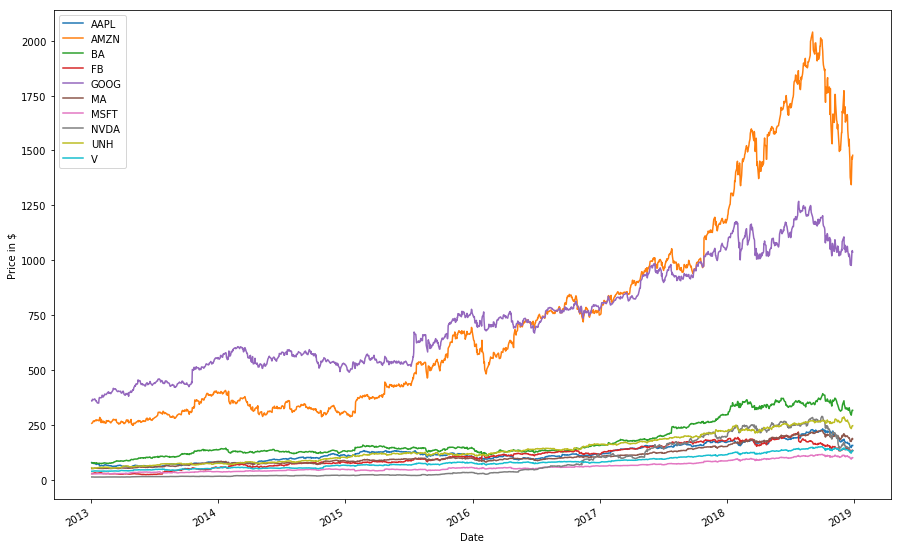

In [53]:
plt.figure(figsize=(15,10))
for stock in stocks:
    data[stock]['close'].plot()
plt.legend(stocks)
plt.ylabel("Price in $")

## Make data compatible with Zipline

In [14]:
# Convert data to panel
StockPrice = pd.Panel(data)
StockPrice.minor_axis = ["open","high","low","close","volume"]
StockPrice.major_axis = StockPrice.major_axis.tz_localize(pytz.utc)
print(StockPrice)

<class 'pandas.core.panel.Panel'>
Dimensions: 10 (items) x 1509 (major_axis) x 5 (minor_axis)
Items axis: AAPL to V
Major_axis axis: 2013-01-02 00:00:00+00:00 to 2018-12-28 00:00:00+00:00
Minor_axis axis: open to volume


In [4]:
# I dont think this does anything
%load_ext zipline

## Set constraints 

In [65]:
# Constraints for our algorithm
initial_capital = 10000
# Time frame for our algorithm
startDate = datetime(2013,1,2,0,0,0,0,pytz.utc)
endDate = datetime(2018,12,28,0,0,0,0,pytz.utc)
# Cost per trade will be 4.95 just because of my brokerage
DEFAULT_MINIMUM_COST_PER_EQUITY_TRADE = 4.95
DEFAULT_MINIMUM_COST_PER_FUTURE_TRADE = 4.95


## Run Algorithm

In [61]:
# Define necessary two functions to run algorithm
def initialize(context):
    context.assest = symbols('GOOG')
    
def handle_data(context, data):
    order(symbol('GOOG'),10)
    record(GOOG = data.current(symbol('GOOG'),'price'))



In [62]:
perf = zipline.run_algorithm(start= startDate,
                            end= endDate,
                            initialize=initialize,
                            data_frequency='daily',
                            capital_base= initial_capital,
                            handle_data=handle_data,
                            data=StockPrice)
perf.head(5)

,GOOG,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2013-01-02 21:00:00+00:00,359.29,NaN,0.000000,NaN,-0.000731,NaN,NaN,0.0000,10000.0000,0.0,...,0.0,0.0,0,NaN,10000.0000,0.0,0.0,1,[],0.0
2013-01-03 21:00:00+00:00,359.50,0.002029,-0.000181,NaN,-0.001461,0.0,NaN,-3596.8075,6403.1925,3595.0,...,0.0,0.0,0,-11.224972,10000.0000,0.0,0.0,2,"[{'amount': 10, 'dt': 2013-01-03 21:00:00+00:0...",0.0
2013-01-04 21:00:00+00:00,366.60,0.064239,0.006735,NaN,-0.002191,0.0,NaN,-3667.8430,2735.3495,7332.0,...,0.0,0.0,0,341.567330,6403.1925,3595.0,3595.0,3,"[{'amount': 10, 'dt': 2013-01-04 21:00:00+00:0...",0.0
2013-01-07 21:00:00+00:00,365.00,0.068784,0.003351,NaN,-0.002921,0.0,NaN,-3651.8350,-916.4855,10950.0,...,0.0,0.0,0,7.959926,2735.3495,7332.0,7332.0,4,"[{'amount': 10, 'dt': 2013-01-07 21:00:00+00:0...",0.0
2013-01-08 21:00:00+00:00,364.28,0.063701,0.001008,NaN,-0.003650,0.0,NaN,-3644.6314,-4561.1169,14571.2,...,0.0,0.0,0,1.802349,-916.4855,10950.0,10950.0,5,"[{'amount': 10, 'dt': 2013-01-08 21:00:00+00:0...",0.0
